# Call record detail (CDR) analysis using K-means clustering

*Project made as an assigment of [Programming with Python for data science](https://www.edx.org/course/programming-python-data-science-microsoft-dat210x-4) course*
___

After the September 11 attacks, a series of secret regulations, laws, and processes were enacted, perhaps to better protect the citizens of the United States. These processes continued through president Bush's term and were renewed and and strengthened during the Obama administration. Then, on May 24, 2006, the United States Foreign Intelligence Surveillance Court (FISC) made a fundamental shift in its approach to Section 215 of the Patriot Act, permitting the FBI to compel production of "business records" relevant to terrorism investigations, which are shared with the NSA. The court now defined as business records the entirety of a telephone company's call database, also known as Call Detail Records (CDR or metadata).

News of this came to public light after Edward Snowden, an ex-NSA contractor leaked the information, and a few more questions were raised when it was further discovered that not just the call records of suspected terrorists were being collected in bulk... but perhaps the entirety of Americans as a whole. After all, if you know someone who knows someone who knows someone, your private records are relevant to a terrorism investigation. The white house quickly reassured the public in a press release that "Nobody is listening to your telephone calls," since, "that's not what this program is about." The public was greatly relieved.

**The questions we try to explore in this analysis are: exactly how useful is telephone metadata? What kind of intelligence can you extract from CDR metadata besides its face value? Are we able to estimate possible home or work place using ones call metadata?**
___

## Undestanding the data

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records for 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!

We will be using a sample CDR dataset generated (CDRs are protected by privacy laws) for 10 people living in the Dallas, Texas metroplex area. Our task will be to attempt to **partly de-anonymize the CDR data**. People generally behave in predictable manners, moving from home to work with a few errands in between. With enough call data, given a few K-locations of interest, K-Means should be able to isolate rather easily the geolocations where a person spends the most of their time.

Here is the structure of the dataset we will be using:
* `In`:phone number of the person being called
* `Out`: caller's phone number
* `Direction`: incoming or missing call?
* `CallDate`: date of call
* `CallTime`: time of call
* `DOW`: day of week
* `Duration`: call duration
* `TowerID`: phone tower ID
* `TowerLat`: phone tower coordinates
* `TowerLon`: phone tower coordinates

We start by loading up the dataset and taking a peek at its head and data types:

In [2]:
import pandas as pd

df = pd.read_csv('Datasets/CDR.csv', header = 0)
print('Colums and its data types: \n', df.dtypes, '\n')
print('Head: \n', df.head())

Colums and its data types: 
 In             int64
Out            int64
Direction     object
CallDate      object
CallTime      object
DOW           object
Duration      object
TowerID       object
TowerLat     float64
TowerLon     float64
dtype: object 

Head: 
            In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  3

We have date and time data stored as numerical. Let's make simple conversion to proper data type.

In [3]:
df['CallDate'] = pd.to_datetime(df['CallDate'])
df['CallTime'] = pd.to_timedelta(df['CallTime'])

df.dtypes

In                     int64
Out                    int64
Direction             object
CallDate      datetime64[ns]
CallTime     timedelta64[ns]
DOW                   object
Duration              object
TowerID               object
TowerLat             float64
TowerLon             float64
dtype: object

# Identifying one user
Now we create a distinct list of `In` phone numbers and store the values in a regular python list in order to "identify" every sigle person in our dataset.

In [4]:
people = pd.unique(df['In'])
people = people.tolist()
people

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

We create a slice named `user1` that filters to _only_ dataset records where the `In` feature (user's phone number) is equal to the first number of our unique list above, i.e., the very first number in the dataset:

In [5]:
user1phone = people[0]
user1 = df[df['In'] == user1phone]
user1.tail()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
53140,4638472273,2666307251,Missed,2013-02-26,11:26:01.888502,Tue,0:03:08.177065,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53141,4638472273,2145623768,Missed,2013-02-26,17:32:18.776276,Tue,0:02:30.823459,78512965-e30b-4734-ae92-47b910fe3d7f,32.899944,-96.910389
53142,4638472273,4551601645,Incoming,2013-02-26,19:12:44.730636,Tue,0:03:42.954201,8fb02570-fb3f-4381-be74-3e1accf87ec5,32.750556,-96.694722
53143,4638472273,7721472178,Incoming,2013-02-26,07:50:41.435642,Tue,0:04:04.460385,e78826ad-45b0-45d4-90ec-4776d73f1d8e,32.864167,-96.836944
53144,4638472273,6150928001,Incoming,2013-02-26,07:49:56.273334,Tue,0:01:35.016406,b0320962-e409-487a-a435-e33ba8123768,32.881111,-96.856389


Let's go ahead and plot all the call locations (or rather locations of phone towers):

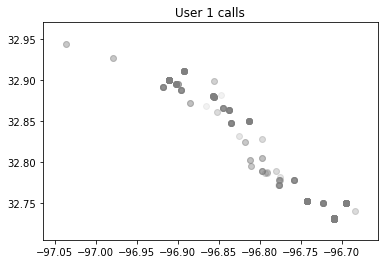

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1['TowerLon'], user1['TowerLat'], c='gray', alpha=0.1)
ax.set_title('User 1 calls')
plt.show()

# Where may User 1 live?
The locations map above may be too "busy". Our intuition can direct us by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

In order to identify User1's calls that came in on weekends we add more filters to the `user1` slice we created:

In [7]:
user1weekends = user1[(user1['DOW'] == 'Sat') | (user1['DOW'] == 'Sun')]

Further we filter `user1` down for calls that came in either before 6AM OR after 10pm (22:00:00). Next we examine how many call came in at that time.

In [8]:
user1wend_nights =  user1weekends[(user1weekends['CallTime'] < '06:00:00') | (user1weekends['CallTime'] > '22:00:00')]
print('Number of weekends\' nights calls:',user1wend_nights.shape[0])

Number of weekends' nights calls: 28


Again we visualize the dataframe with a scatter plot.

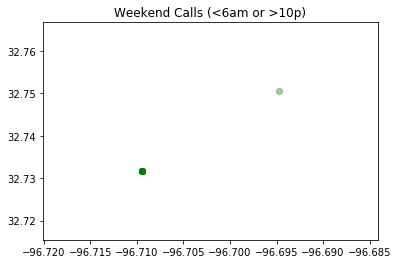

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1wend_nights.TowerLon,user1wend_nights.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')
plt.show()

At this point, we don't yet know exactly where the user is located just based off the cell phone tower position data; but considering the above are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence.

In order to idenify this place we run K-Means with a `K=1`.

[[-96.70839404  32.73299989]]


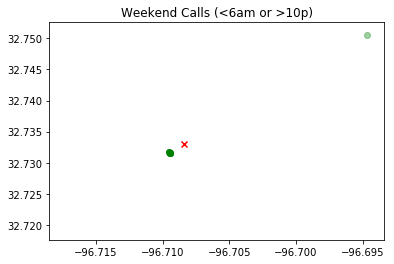

In [10]:
# get rid of unnecesary columns
# since both Lat and Lon are on the same scale, no feature scaling is required.
user1wend_nights = user1wend_nights[['TowerLon', 'TowerLat']] 

#modeling K-means
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 1)
model.fit(user1wend_nights)

# lest store centroid
centroids = model.cluster_centers_
print(centroids)

# plot call locations with centroid
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(centroids[:,0], centroids [:,1], c = 'r', marker = 'x')
ax.scatter(user1wend_nights.TowerLon,user1wend_nights.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')

plt.show()

There really should only be a single area of concentration. As we notice there are multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another), so we increase number of clusters to `K=2`, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home:

[[-96.70944573  32.73164942]
 [-96.694722    32.750556  ]]


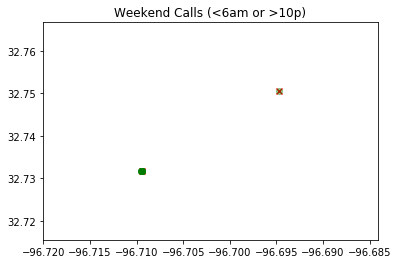

In [11]:
#modeling K-means
n_clusters = 2

model = KMeans(n_clusters = n_clusters)
model.fit(user1wend_nights)

# lest print centroid
centroids = model.cluster_centers_
print(centroids)

# plot call locations with centroid
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(centroids[:,0], centroids [:,1], c = 'r', marker = 'x')
ax.scatter(user1wend_nights.TowerLon,user1wend_nights.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')

plt.show()

We can assume that every first centroid referst to approximate residence of user. We this assertion we are able to draw a map with probable location of every user's home place!

# Identifying home places of all users

Now that we have a system in place, we repeat the above steps for all 10 individuals in the dataset, being sure to record their approximate home locations:

tel num: 	 4638472273
centroids:
 [[-96.70944573  32.73164942]
 [-96.694722    32.750556  ]] 



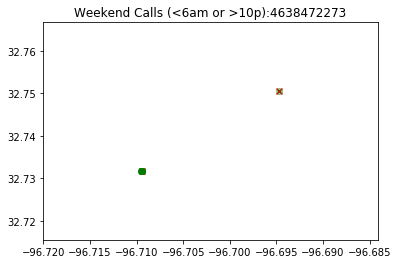

tel num: 	 1559410755
centroids:
 [[-96.92355156  32.87096756]
 [-96.923556    32.871111  ]] 



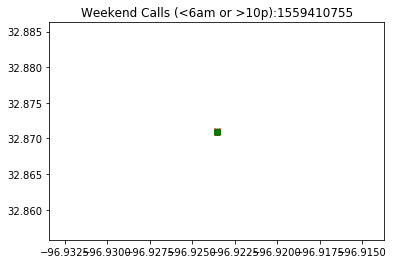

tel num: 	 4931532174
centroids:
 [[-96.865298    32.86592718]
 [-96.864444    32.857778  ]] 



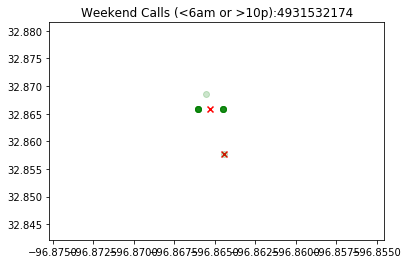

tel num: 	 2419930464
centroids:
 [[-96.83515822  32.84635163]
 [-96.852389    32.861222  ]] 



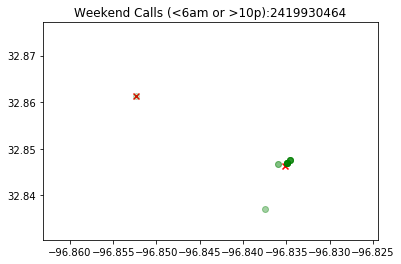

tel num: 	 1884182865
centroids:
 [[-96.730278  32.875   ]
 [-96.759694  32.917333]] 



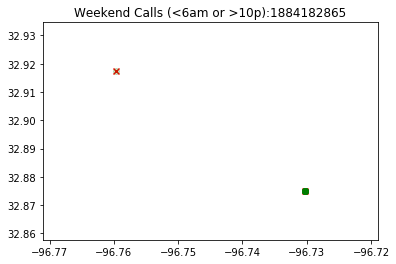

tel num: 	 3688089071
centroids:
 [[-96.685556  32.770833]
 [-96.685556  32.770833]] 



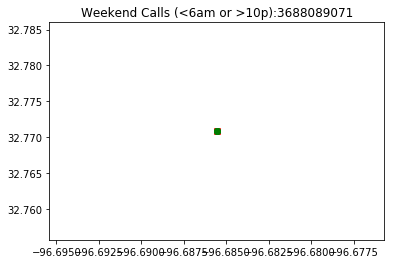

tel num: 	 4555003213
centroids:
 [[-96.840667  32.705222]
 [-96.840556  32.695   ]] 



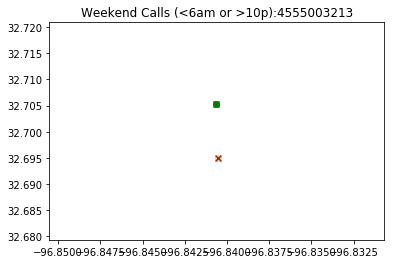

tel num: 	 2068627935
centroids:
 [[-96.604444  32.703056]
 [-96.604444  32.703056]] 



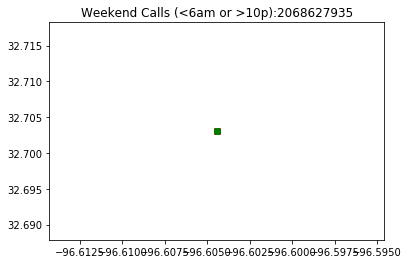

tel num: 	 2894365987
centroids:
 [[-96.81277401  32.77401172]
 [-96.920139    32.702     ]] 



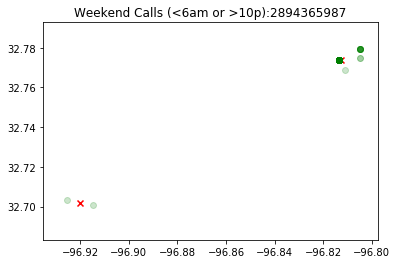

tel num: 	 8549533077
centroids:
 [[-96.77946848  32.7722949 ]
 [-96.831472    33.01525   ]] 



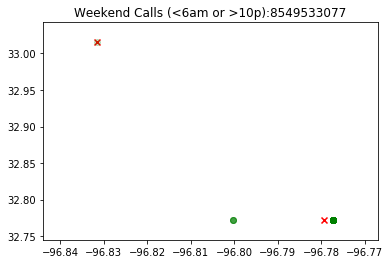

In [12]:
for i in people:
    
    # prepare set of user's data
    userdata = df[df['In'] == i]
    userdata = userdata[(userdata['DOW'] == 'Sat') | (userdata['DOW'] == 'Sun')]
    userdata = userdata[(userdata['CallTime'] < '06:00:00') | (userdata['CallTime'] > '22:00:00')]
    userdata = userdata[['TowerLon', 'TowerLat']]
    
    # model K-means
    model = KMeans(n_clusters = 2)
    model.fit(userdata)

    # obtain centroids
    centroids = model.cluster_centers_
    print ('tel num: \t',i)
    print('centroids:\n', centroids, '\n')
  
  
    #plot charts
    
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.scatter(centroids[:,0], centroids [:,1], c = 'r', marker = 'x')
    ax.scatter(userdata.TowerLon,userdata.TowerLat, c='g', marker='o', alpha=0.2)
    ax.set_title('Weekend Calls (<6am or >10p):' + str(i))
    plt.show()    

We modfiy a bit code from previous cell in order to receive a list of probable home place location for every user:

In [13]:
people_locations = []

for i in people:
    
    userdata = df[df['In'] == i]
    userdata = userdata[(userdata['DOW'] == 'Sat') | (userdata['DOW'] == 'Sun')]
    userdata = userdata[(userdata['CallTime'] < '06:00:00') | (userdata['CallTime'] > '22:00:00')]
    userdata = userdata[['TowerLon', 'TowerLat']]
        
    model = KMeans(n_clusters = 2)
    model.fit(userdata)
    
    centroids = model.cluster_centers_
    people_locations.append(centroids[0])   

Last thing to do is to drwa a map with all user locations. To do that we are going to user Folium package.

In [15]:
import folium

print('Probable home places of 10 individuals')
map = folium.Map(location = [32.7767, -96.7970], zoom_start=11)
for i in range(len(people_locations)):
    folium.CircleMarker([people_locations[i][1], people_locations[i][0]],
                        radius = 20,
                        color='#3186cc',
                        fill_color='#3186cc',
                        popup = ('user ' + str(i+1) + '\t' + str(people_locations[i]))
                       ).add_to(map)
map

Probable home places of 10 individuals


# Conclusions
Proving that metadata are used for spying people is not the goal or object of interests of this analysis. The main objective was to check out if it is even possible.

It looks like call detail records or metadata are quite helpful if we want to estimate where particular individual live or spend most of his time. In this analysis, we presented the method to estimate probable home place. Using this method we would be able to specify where the person works, where he spends free time, what venues usually visits.


We could continue asking more questions and try to check out how useful CDR may be if we want to analyse behavioural patterns, ways of spending free time, reconstruct contacts network of a particular individual.